In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [94]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [104]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, text

In [24]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [126]:
# reflect an existing database into a new model
inspector = inspect(engine)
# reflect the tables
Base = automap_base()
Base.prepare(autoload_with=engine)
Base.classes.keys()

['measurement', 'station']

In [34]:
# View all of the classes that automap found
inspector.get_table_names()

['measurement', 'station']

In [28]:
columns_measurement = inspector.get_columns('measurement')
for column in columns_measurement:
    print(column['name'],column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [30]:
columns_station = inspector.get_columns('station')
for column in columns_station:
    print(column['name'],column['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [46]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station
print(Measurement)
print(Station)

<class 'sqlalchemy.ext.automap.measurement'>
<class 'sqlalchemy.ext.automap.station'>


In [42]:
# Create our session (link) from Python to the DB
session = Session(engine)
print(session)

# Exploratory Precipitation Analysis

In [56]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23',)

('2017-08-23',)


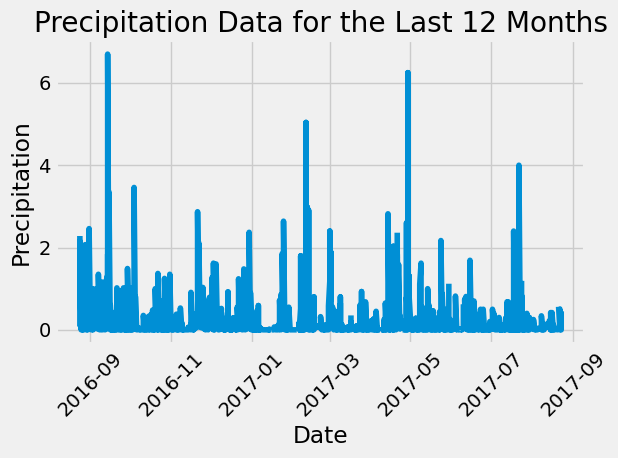

In [120]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
rec_date_row = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(rec_date_row)
# Calculate the date one year from the last date in data set.
if rec_date_row:
    rec_date = rec_date_row[0]
    end_date = dt.datetime.strptime(rec_date, '%Y-%m-%d')
    start_date = end_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
# Sort the dataframe by date    
    query = text("""
            SELECT date, prcp
            FROM measurement
            WHERE date BETWEEN :start_date AND :end_date
            ORDER BY date ASC
            """)
# Save the query results as a Pandas DataFrame. Explicitly set the column names
prcp_df = pd.read_sql(query, engine, params={'start_date': start_date, 'end_date': end_date})
prcp_df.columns = ['date','prcp']

# Use Pandas Plotting with Matplotlib to plot the data
plt.plot(pd.to_datetime(prcp_df['date']), prcp_df['prcp'])
plt.title('Precipitation Data for the Last 12 Months')
plt.xlabel('Date')
plt.ylabel('Precipitation')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [122]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = prcp_df['prcp'].describe()
summary_stats

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64

# Exploratory Station Analysis

In [124]:
# Design a query to calculate the total number of stations in the dataset
session.query(func.count(Station.id)).all()

[(9,)]

In [134]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
query = text(""" 
            SELECT station, COUNT(*) AS count
            FROM Measurement
            GROUP BY station
            ORDER BY count DESC
            """)
# List the stations and their counts in descending order.
stations_df = pd.read_sql(query,engine)
print(stations_df)

       station  count
0  USC00519281   2772
1  USC00519397   2724
2  USC00513117   2709
3  USC00519523   2669
4  USC00516128   2612
5  USC00514830   2202
6  USC00511918   1979
7  USC00517948   1372
8  USC00518838    511


In [148]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = stations_df.iloc[0]['station']

temp_query = text("""
            SELECT
                MIN(tobs) AS Lowest_Temp,
                MAX(tobs) AS Highest_Temp,
                AVG(tobs) AS Average_Temp
            FROM Measurement
            WHERE station = :station
            """)
temp_stats = pd.read_sql(temp_query, engine, params={'station': most_active_station})
temp_stats

,Lowest_Temp,Highest_Temp,Average_Temp
0,54.0,85.0,71.663781


In [ ]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
rec_date_row = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(rec_date_row)
# Calculate the date one year from the last date in data set.
if rec_date_row:
    rec_date = rec_date_row[0]
    end_date = dt.datetime.strptime(rec_date, '%Y-%m-%d')
    start_date = end_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
# Sort the dataframe by date    
    query = text("""
            SELECT date, prcp
            FROM measurement
            WHERE date BETWEEN :start_date AND :end_date
            ORDER BY date ASC
            """)
# Save the query results as a Pandas DataFrame. Explicitly set the column names
prcp_df = pd.read_sql(query, engine, params={'start_date': start_date, 'end_date': end_date})
prcp_df.columns = ['date','prcp']

# Use Pandas Plotting with Matplotlib to plot the data
plt.plot(pd.to_datetime(prcp_df['date']), prcp_df['prcp'])
plt.title('Precipitation Data for the Last 12 Months')
plt.xlabel('Date')
plt.ylabel('Precipitation')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

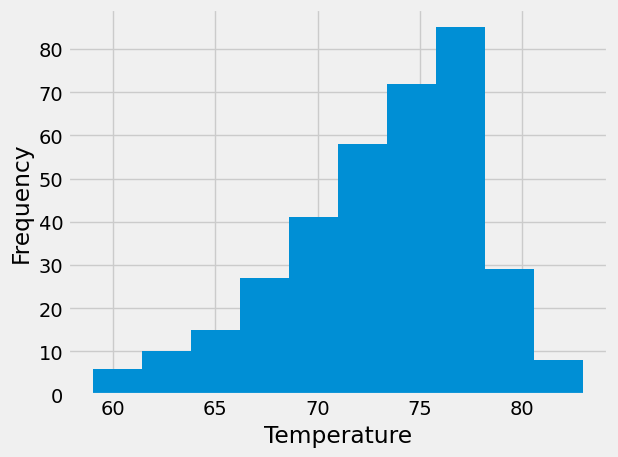

In [156]:
# Using the most active station id
rec_date_row = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
# Calculate the date one year from the last date in data set.
if rec_date_row:
    rec_date = rec_date_row[0]
    end_date = dt.datetime.strptime(rec_date, '%Y-%m-%d')
    start_date = end_date - dt.timedelta(days=365)
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
    query_temp_observations = text("""
        SELECT tobs
        FROM Measurement
        WHERE station = :station
          AND date BETWEEN :start_date AND :end_date
    """)

    df_temp_observations = pd.read_sql(query_temp_observations, engine, 
                                       params={'station': most_active_station, 
                                               'start_date': start_date, 
                                               'end_date': end_date})

# Plot the temperature observations as a histogram
plt.hist(df_temp_observations['tobs'])
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

# Close Session

In [16]:
# Close Session
session.close()